## Extract the subjects view

In [1]:
import os
import scipy.io as sio
import numpy as np

In [2]:
def handle_subj_ops(subj):
    subj_file = os.path.join(src_fold, 'subject' + format(subj)+ '.mat')
    data = sio.loadmat(subj_file)['A']
    # eliminate unwanted regions
    #data = data[:, mask]

    #subj_dest_fold = os.path.join(dst_fold, 'subject' + format(subj))
    #os.mkdir(subj_dest_fold)
    return data


In [3]:
def extract_subj_store(subj, data):

    #subj_dest_fold = os.path.join(dst_fold, 'subject' + format(subj))
    #Proceeded by transpose  to obtain 4 matrices for each subject, already checked that it is symmetric
    data=data.transpose(2,0,1)
    #the first matrix (network) in the dataset (over 4)
    #upper_tri=np.triu(data[0])
    matrix=data[0]
    #Vectorize 
    ui=np.triu_indices(35)
    vector=matrix[ui]
    

    #f = os.path.join(subj_dest_fold, 'subjectA'+ format(subj)  + '.mat' )
    ## needed data for classification, labels and features(brain grahps' weights in our case)
    #d = {}
    #d ['vector']=vector
    #sio.savemat(f,d)
    return vector

In [4]:
def create_dataset(subjects,src_fold,dst_fold):
    #subj_dest_fold = os.path.join(dst_fold, 'subject' + format(subj))
    d={}
    Features_vectors=[0 for i in range(630)]
    #v=np.array([[0 for i in range(630)]])
    for subj in subjects:
        subj_data=handle_subj_ops(subj)
        vector=extract_subj_store(subj,subj_data)
        Features_vectors=np.vstack((Features_vectors,vector))
        
        #v=np.append(v,np.array(vector))
        #d['subject'+format(subj)]=vector
    #d['A']=v
    Features_vectors=np.delete(Features_vectors,0,0)
    d['Features_vectors_RH']=Features_vectors
    f = os.path.join(dst_fold, 'Feature_vectors_RH' + '.mat' )
    sio.savemat(f,d)    
    

### --------------------Main------------------------

In [6]:
src_fold  = '/home/raoua/Desktop/BASIRA/working repo/Data_77subjects/RH77subjects/'
label_file = '/home/raoua/Desktop/BASIRA/working repo/Data_77subjects/labels77.mat'
dst_fold = '/home/raoua/Desktop/BASIRA/working repo/intermediate_RH/'def fisher_score_FS(X_train,y_train):
    score = fisher_score.fisher_score(X_train, y_train)
    idx = fisher_score.feature_ranking(score)
    return(idx)

In [8]:
subjects=range(1,78)
#for subj in subjects:
#    # read and create necessary folders
#    subj_data = handle_subj_ops(subj)
#    extract_subj_store(subj, subj_data)
create_dataset(subjects,src_fold,dst_fold)

### Start over here 

In [1]:
import scipy.io as sio
import numpy as np

### Read the data

In [2]:
Data=sio.loadmat('./intermediate_RH/Feature_vectors_RH.mat')
X=Data['Features_vectors_RH']
X = X.astype(float)
labels=sio.loadmat('./labels77.mat')
y=labels['labels']

### Data cleaning

In [3]:
#I transposed it the first time because the next operation of dropping the null values does not work for axis =0 
X=np.transpose(X)
X = X[~np.all(X == 0, axis=1)]
# Itranspose it back to not change the next operations 
X=np.transpose(X)

### Feature selection

In [4]:
y=y[:, 0]
n_samples, n_features = X.shape    # number of samples and number of features

### Import cross validations modules and linear SVM

In [5]:
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneOut

# split data into 5 folds
kf5=KFold(n_splits=5,shuffle=True)
#kf5.get_n_splits(X)
kf10=KFold(n_splits=5,shuffle=True)
loo=LeaveOneOut()
# Number of selected features (top k ranked features)
#top K selected features varying from 10 to 100 (with a step size of 10 features)
num_fea = [i for i in range(10,110,10)]
clf = svm.LinearSVC()    # linear SVM

### Import all the feature selection features

In [6]:
from skfeature.function.similarity_based import reliefF
#MutInfFS
from skfeature.function.information_theoretical_based import MIFS
#laplacian
from skfeature.function.similarity_based import lap_score
from skfeature.utility import construct_W
# norm
from skfeature.function.sparse_learning_based import ll_l21
from skfeature.utility.sparse_learning import *
#UDFS
from skfeature.function.sparse_learning_based import UDFS
from skfeature.utility.sparse_learning import feature_ranking
from skfeature.function.similarity_based import fisher_score
from skfeature.function.statistical_based import chi_square
from skfeature.function.statistical_based import gini_index
from skfeature.function.information_theoretical_based import FCBF
from skfeature.function.similarity_based import trace_ratio
from skfeature.function.similarity_based import SPEC
from skfeature.function.information_theoretical_based import CIFE
from skfeature.function.streaming import alpha_investing
from skfeature.function.information_theoretical_based import CMIM
from skfeature.function.sparse_learning_based import ls_l21
from skfeature.function.sparse_learning_based import MCFS
from skfeature.utility import construct_W
# Borutapy
from boruta_py.boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

### Import all the defined functions from FS_methods file

In [7]:
import FS_methods as fl

In [8]:
def training(cv,k,FS_method):
    accuracy=[]
    featureranking=[]
    featureweight=[]
    correct=0
    for train_index, test_index in cv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if FS_method==reliefF:
            idx,score=fl.relief_FS(X_train,y_train)
        #elif FS_method==MIFS: ##ERROR
        #    idx,score=MIFS_FS(k,X_train,y_train)
        elif FS_method==lap_score:
            idx,score=fl.lap_score_FS(X)
        elif FS_method==ll_l21:
            idx,score=fl.ll_l21_FS(X_train,y,train_index)
        elif FS_method==UDFS:
            idx,score=fl.UDFS_FS(X)
        elif FS_method==fisher_score:
            idx,score=fl.fisher_score_FS(X_train,y_train)
        elif FS_method==chi_square:
            idx,score=fl.chi_square_FS(X_train,y_train)
        elif FS_method==gini_index:
            idx,score=fl.gini_index_FS(X_train,y_train)
        #elif FS_method==FCBF:
        #    idx=FCBF_FS(X_train,y_train,k)
        elif FS_method==BorutaPy:
            idx=boruta_FS(X_train,y_train) 
            score=np.nana
        #elif FS_method==trace_ratio:
        #    idx=trace_ratio_FS(X,train_index,y_train)
        elif FS_method==SPEC:
            idx,score=fl.spec_FS(X_train)
        #elif FS_method==CIFE:#Takes too long 
        #    idx=CIFE_FS(X_train,y_train)
        #elif FS_method==alpha_investing:#Error
        #    idx=alpha_investing_FS(X_train,y_train)
        #elif FS_method==CMIM:# Same ranking of the original features 
         #   n,m=X_train.shape
         #   idx=CMIM_FS(X_train,y_train,m)
        elif FS_method==ls_l21:
            idx,score=fl.ls_l21_FS(X_train,y,train_index)
        #elif FS_method==MCFS:
         #   idx=MCFS_FS(X_train,k)
        
        selected_features = X[:, idx[0:k]]
        featureranking.extend([idx])
        featureweight.extend([score])

        # train a classification model with the selected features on the training dataset
        clf.fit(selected_features[train_index], y[train_index])  # predict the class labels of test data
        y_predict = clf.predict(selected_features[test_index])
        # obtain the classification accuracy on the test data
        acc = accuracy_score(y[test_index], y_predict)
        correct = correct + acc

        # output the average classification accuracy over all folds
    accuracy=float(correct)/cv.get_n_splits(X)
    return(np.array(featureranking),accuracy,np.array(featureweight))

### Pool of feature selection

In [9]:
pool_FS=[reliefF,lap_score,ll_l21,ls_l21,UDFS,fisher_score,chi_square,gini_index,SPEC]#,BorutaPy]#,MCFS]#trace_ratio,

### Create Dataframes of FS methods for each k for 3 CV methods

#### 5-fold cv

In [12]:
import pandas as pd
#labels=['reliefF','lap_score','ll_l21']
labels=['reliefF','lap_score','ll_l21','ls_l21','UDFS','fisher_score','chi_square','gini_index','SPEC']

dataframe_ranking=pd.DataFrame(index=num_fea,columns=labels)
dataframe_weights=pd.DataFrame(index=num_fea,columns=labels)
dataframe_accuracies=pd.DataFrame(index=num_fea,columns=labels)

In [13]:
#matrix_=np.zeros((50,589*3))
for i in range(len(pool_FS)):
    for k in num_fea:
        ranking__,acc__,weight__=training(kf5,k,pool_FS[i])
        dataframe_ranking[labels[i]][k]=ranking__
        dataframe_weights[labels[i]][k]=weight__
        dataframe_accuracies[labels[i]][k]=acc__
        

In [14]:
dataframe_ranking_5fold=dataframe_ranking.copy()
dataframe_weights_5fold=dataframe_weights.copy()
dataframe_accuracies_5fold=dataframe_accuracies.copy()

In [1]:
dataframe_ranking_5fold

NameError: name 'dataframe_ranking_5fold' is not defined

#### 10-fold cv

In [15]:
for i in range(len(pool_FS)):
    for k in num_fea:
        ranking__,acc__,weight__=training(kf10,k,pool_FS[i])
        dataframe_ranking[labels[i]][k]=ranking__
        dataframe_weights[labels[i]][k]=weight__
        dataframe_accuracies[labels[i]][k]=acc__
        

In [16]:
dataframe_ranking_10fold=dataframe_ranking.copy()
dataframe_weights_10fold=dataframe_weights.copy()
dataframe_accuracies_10fold=dataframe_accuracies.copy()

#### LOO

In [23]:
for i in range(len(pool_FS)):
    for k in num_fea:
        ranking__,acc__,weight__=training(loo,k,pool_FS[i])
        dataframe_ranking[labels[i]][k]=ranking__
        dataframe_weights[labels[i]][k]=weight__
        dataframe_accuracies[labels[i]][k]=acc__

In [24]:
dataframe_ranking_loo=dataframe_ranking.copy()
dataframe_weights_loo=dataframe_weights.copy()
dataframe_accuracies_1oo=dataframe_accuracies.copy()

### Similarity functions

In [32]:
def intersection(a,b):
    sum_=0
    for x in range(a.shape[0]):
        for y in range(a.shape[1]):
            sum_+=np.sum((a[x,y]==b[x,y]))
    percentage=(sum_*100)/a.size
    return(percentage)

In [33]:
def FS_to_FS_similarity(FS_k):
    n=len(FS_k)
    m=np.ones((n,n))
    for i in range(n-1):
        for j in range(i+1,n):
            m[i,j]=intersection(FS_k[i],FS_k[j])
            m[j,i]=m[i,j]
    for i in range(n):
        m[i,i]=intersection(FS_k[i],FS_k[i])/100
    return(m)

In [34]:

def avg_similarity(pool_FS,num_fea,cv):
    '''Input:
    
       pool_FS: pool of Feature selection methods
       num_fea: a list of different fs numbers in this case the threshold varies from 10 to 100 with step 10
       cv: Cross validation method (5-fold, 10_fold, LOO)
       
       Output: 
       
       average_similarity: average similarity matrix'''
    S_k={}
    similarities=[]
    for k in num_fea:
        FS_k=[]
    
        for FS in pool_FS:
            _feature_ranking,_acc=training(cv,k,FS)
            #FS_k_ranking.append(_feature_ranking)
            FS_k.append(_feature_ranking)
        S_k[k]=FS_to_FS_similarity(FS_k)
    for k in num_fea:
        similarities.append(S_k[k])
    average_similarity=sum(similarities)/len(num_fea)
    return(average_similarity,S_k)

##### Accuracy similarity matrix

In [35]:
from statistics import mean
import math
def cost(ai,aj):
    sigma=10
    return(math.exp(-abs(ai-aj)/sigma))

In [36]:
def matrix_acc(list_):
    n=len(list_)
    m=np.ones((n,n))
    for i in range(n-1):
        for j in range(i+1,n):
            m[i,j]=cost(list_[i],list_[j])
            m[j,i]=m[i,j]
    for i in range(n):
        m[i,i]=cost(list_[i],list_[i])
    
    return(m)

In [37]:
def accuracy_similarity_matrix(pool_FS,num_fea,cv):
    '''Input:
    
       pool_FS: pool of Feature selection methods
       num_fea: a list of different fs numbers in this case the threshold varies from 10 to 100 with step 10
       cv: Cross validation method (5-fold, 10_fold, LOO)
       
       Output:
       FS-to-FS Accuracy similarity matrix
       
    '''
    #avg_fs_acc_over_k={}
    avg_fs_acc_over_k=[]
    #FS_columns=['reliefF','lap_score','ll_l21','UDFS','fisher_score','chi_square','gini_index']
    for FS in pool_FS:
        acc_k=[]
        for k in num_fea:
            _feature_ranking,_acc=training(cv,k,FS)
            #avg_fs_acc_over_k[k]=
            acc_k.append(_acc)
        #avg_fs_acc_over_k[str(FS.__name__.split('.')[3])]=mean(acc_k)
        avg_fs_acc_over_k.append(mean(acc_k))
    result=matrix_acc(avg_fs_acc_over_k)
    return(result)

### Overlapping matrices 

##### Generating

In [ ]:
dataframe_ranking_loo

In [38]:
dataframe_ranking_5fold['overlapping']=dataframe_ranking_5fold.apply(
    lambda row:FS_to_FS_similarity(row),axis=1)

In [39]:
dataframe_ranking_10fold['overlapping']=dataframe_ranking_10fold.apply(
    lambda row:FS_to_FS_similarity(row),axis=1)

In [40]:
dataframe_ranking_loo['overlapping']=dataframe_ranking_loo.apply(
    lambda row:FS_to_FS_similarity(row),axis=1)

#### Plot

##### 5-fold

Text(0.5, 1.0, 'num_fea=100')

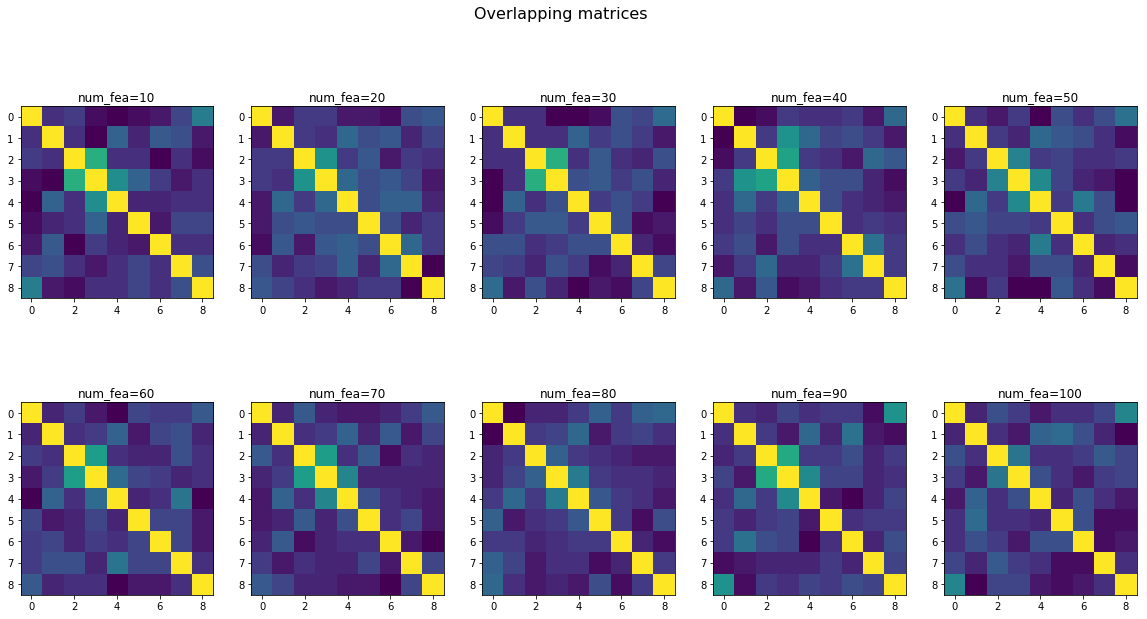

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.suptitle('Overlapping matrices', fontsize=16)

plt.subplot(2, 5, 1)
plt.imshow(dataframe_ranking_5fold.overlapping[10])
plt.title('num_fea=10')
plt.subplot(2, 5, 2)
plt.imshow(dataframe_ranking_5fold.overlapping[20])
plt.title('num_fea=20')
plt.subplot(2, 5, 3)
plt.imshow(dataframe_ranking_5fold.overlapping[30])
plt.title('num_fea=30')
plt.subplot(2, 5, 4)
plt.imshow(dataframe_ranking_5fold.overlapping[40])
plt.title('num_fea=40')
plt.subplot(2, 5, 5)
plt.imshow(dataframe_ranking_5fold.overlapping[50])
plt.title('num_fea=50')
plt.subplot(2, 5, 6)
plt.imshow(dataframe_ranking_5fold.overlapping[60])
plt.title('num_fea=60')
plt.subplot(2, 5, 7)
plt.imshow(dataframe_ranking_5fold.overlapping[70])
plt.title('num_fea=70')
plt.subplot(2, 5, 8)
plt.imshow(dataframe_ranking_5fold.overlapping[80])
plt.title('num_fea=80')
plt.subplot(2, 5, 9)
plt.imshow(dataframe_ranking_5fold.overlapping[90])
plt.title('num_fea=90')
plt.subplot(2, 5, 10)
plt.imshow(dataframe_ranking_5fold.overlapping[100])
plt.title('num_fea=100')


##### 10-fold

Text(0.5, 1.0, 'num_fea=100')

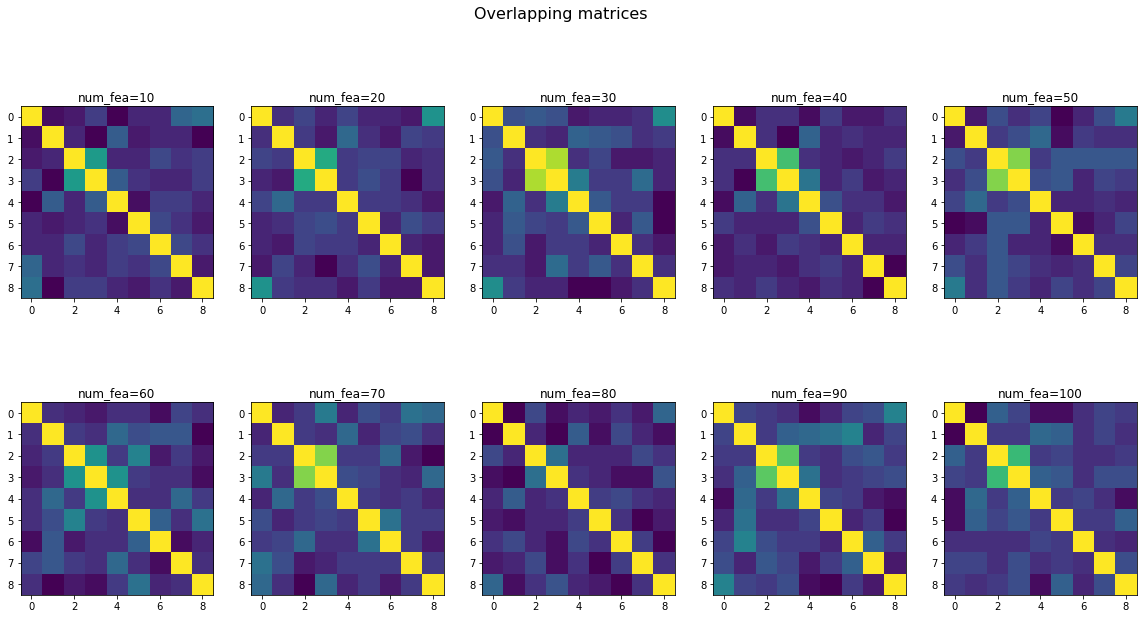

In [42]:
plt.figure(figsize=(20,10))
plt.suptitle('Overlapping matrices', fontsize=16)

plt.subplot(2, 5, 1)
plt.imshow(dataframe_ranking_10fold.overlapping[10])
plt.title('num_fea=10')
plt.subplot(2, 5, 2)
plt.imshow(dataframe_ranking_10fold.overlapping[20])
plt.title('num_fea=20')
plt.subplot(2, 5, 3)
plt.imshow(dataframe_ranking_10fold.overlapping[30])
plt.title('num_fea=30')
plt.subplot(2, 5, 4)
plt.imshow(dataframe_ranking_10fold.overlapping[40])
plt.title('num_fea=40')
plt.subplot(2, 5, 5)
plt.imshow(dataframe_ranking_10fold.overlapping[50])
plt.title('num_fea=50')
plt.subplot(2, 5, 6)
plt.imshow(dataframe_ranking_10fold.overlapping[60])
plt.title('num_fea=60')
plt.subplot(2, 5, 7)
plt.imshow(dataframe_ranking_10fold.overlapping[70])
plt.title('num_fea=70')
plt.subplot(2, 5, 8)
plt.imshow(dataframe_ranking_10fold.overlapping[80])
plt.title('num_fea=80')
plt.subplot(2, 5, 9)
plt.imshow(dataframe_ranking_10fold.overlapping[90])
plt.title('num_fea=90')
plt.subplot(2, 5, 10)
plt.imshow(dataframe_ranking_10fold.overlapping[100])
plt.title('num_fea=100')


##### LOO

Text(0.5, 1.0, 'num_fea=100')

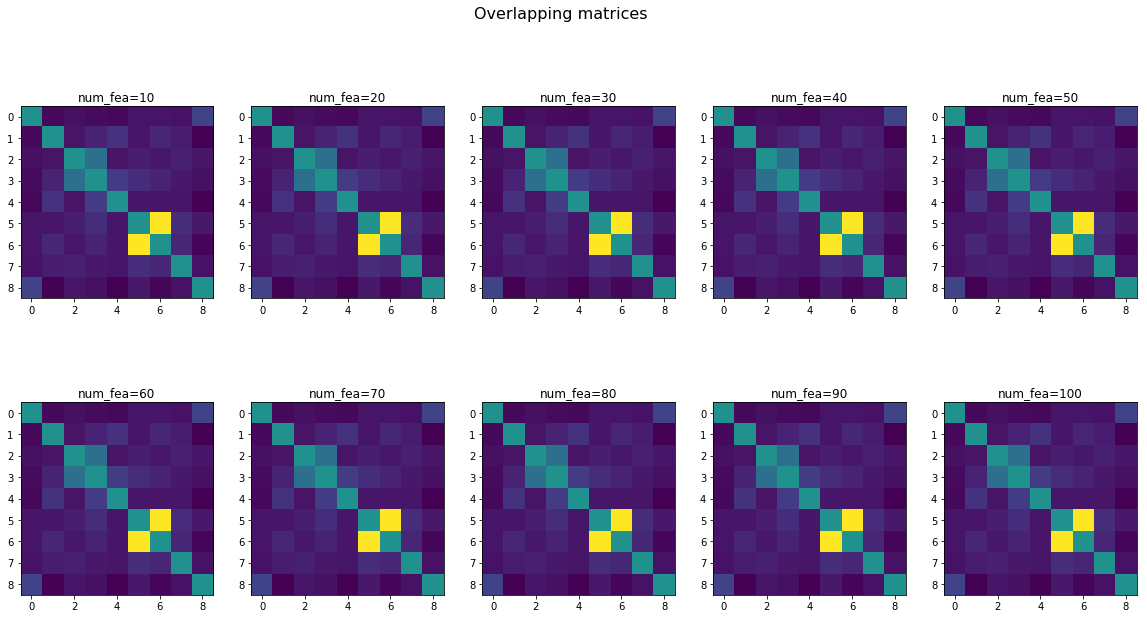

In [43]:
plt.figure(figsize=(20,10))
plt.suptitle('Overlapping matrices', fontsize=16)

plt.subplot(2, 5, 1)
plt.imshow(dataframe_ranking_loo.overlapping[10])
plt.title('num_fea=10')
plt.subplot(2, 5, 2)
plt.imshow(dataframe_ranking_loo.overlapping[20])
plt.title('num_fea=20')
plt.subplot(2, 5, 3)
plt.imshow(dataframe_ranking_loo.overlapping[30])
plt.title('num_fea=30')
plt.subplot(2, 5, 4)
plt.imshow(dataframe_ranking_loo.overlapping[40])
plt.title('num_fea=40')
plt.subplot(2, 5, 5)
plt.imshow(dataframe_ranking_loo.overlapping[50])
plt.title('num_fea=50')
plt.subplot(2, 5, 6)
plt.imshow(dataframe_ranking_loo.overlapping[60])
plt.title('num_fea=60')
plt.subplot(2, 5, 7)
plt.imshow(dataframe_ranking_loo.overlapping[70])
plt.title('num_fea=70')
plt.subplot(2, 5, 8)
plt.imshow(dataframe_ranking_loo.overlapping[80])
plt.title('num_fea=80')
plt.subplot(2, 5, 9)
plt.imshow(dataframe_ranking_loo.overlapping[90])
plt.title('num_fea=90')
plt.subplot(2, 5, 10)
plt.imshow(dataframe_ranking_loo.overlapping[100])
plt.title('num_fea=100')


### Average similarities

In [44]:
import seaborn as sns 
sns.set()

Text(0.5, 1.0, 'Average similarity case 5 fold CV')

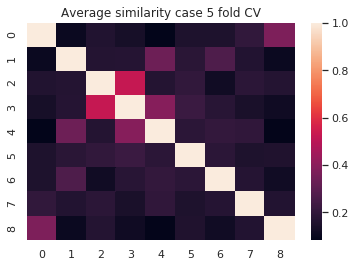

In [45]:
sns.heatmap(dataframe_ranking_5fold.overlapping.mean())
plt.title('Average similarity case 5 fold CV')

Text(0.5, 1.0, 'Average similarity case 10 fold CV')

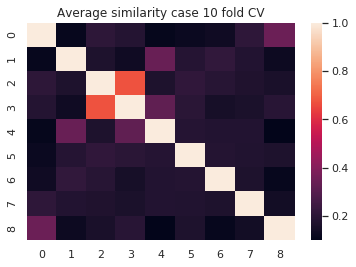

In [46]:
sns.heatmap(dataframe_ranking_10fold.overlapping.mean())
plt.title('Average similarity case 10 fold CV')

Text(0.5, 1.0, 'Average similarity case LOO CV')

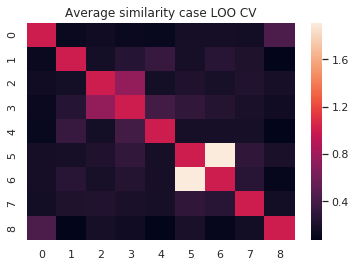

In [47]:
sns.heatmap(dataframe_ranking_loo.overlapping.mean())
plt.title('Average similarity case LOO CV')

### Accuracy similarity matrices

In [48]:
df_5fold_acc=dataframe_accuracies_5fold.copy()

In [49]:
df_5fold_acc.loc['mean'] =df_5fold_acc.mean()

In [50]:
acc_sim_matrice_5fold=matrix_acc(list(df_5fold_acc.loc['mean']))

Text(0.5, 1.0, 'Accuracy similarity matrice: 5-fold cv')

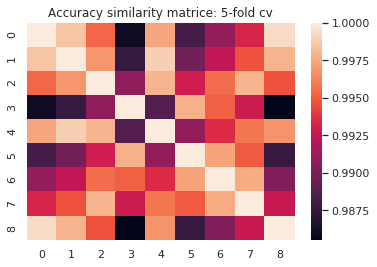

In [51]:
sns.heatmap(acc_sim_matrice_5fold)
plt.title('Accuracy similarity matrice: 5-fold cv')

In [52]:
df_10fold_acc=dataframe_accuracies_10fold.copy()

In [53]:
df_10fold_acc.loc['mean'] =df_10fold_acc.mean()

In [54]:
acc_sim_matrice_10fold=matrix_acc(list(df_10fold_acc.loc['mean']))

Text(0.5, 1.0, 'Accuracy similarity matrice: 10-fold cv')

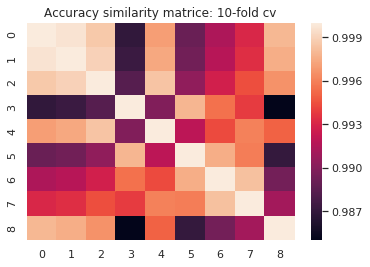

In [55]:
sns.heatmap(acc_sim_matrice_10fold)
plt.title('Accuracy similarity matrice: 10-fold cv')

In [57]:
df_loo_acc=dataframe_accuracies_1oo.copy()

In [59]:
df_loo_acc.loc['mean'] =df_loo_acc.mean()

In [60]:
acc_sim_matrice_loo=matrix_acc(list(df_loo_acc.loc['mean']))

Text(0.5, 1.0, 'Accuracy similarity matrice: LOO cv')

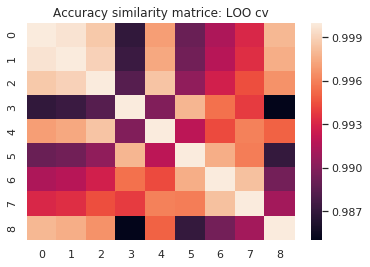

In [61]:
sns.heatmap(acc_sim_matrice_10fold)
plt.title('Accuracy similarity matrice: LOO cv')

### Final similarity matrix without stability

Text(0.5, 1.0, 'Final similarity matrice without stability: 5-fold cv')

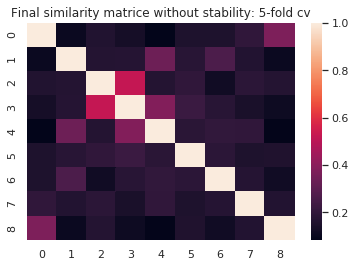

In [62]:
avg_sim_5fold=dataframe_ranking_5fold.overlapping.mean()
Final_sim_5fold=np.multiply(avg_sim_5fold,acc_sim_matrice_5fold)
sns.heatmap(Final_sim_5fold)
plt.title('Final similarity matrice without stability: 5-fold cv')

Text(0.5, 1.0, 'Final similarity matrice without stability: 10-fold cv')

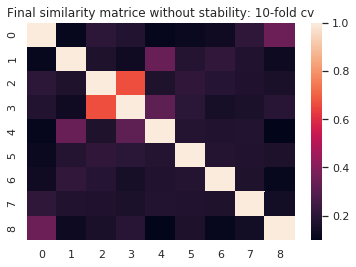

In [63]:
avg_sim_10fold=dataframe_ranking_10fold.overlapping.mean()
Final_sim_10fold=np.multiply(avg_sim_10fold,acc_sim_matrice_10fold)
sns.heatmap(Final_sim_10fold)
plt.title('Final similarity matrice without stability: 10-fold cv')

Text(0.5, 1.0, 'Final similarity matrice without stability: LOO cv')

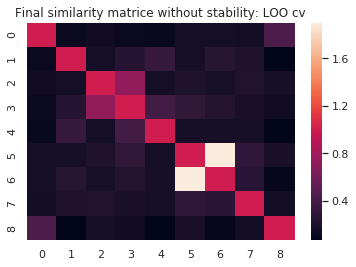

In [64]:
avg_sim_loo=dataframe_ranking_loo.overlapping.mean()
Final_sim_loo=np.multiply(avg_sim_loo,acc_sim_matrice_loo)
sns.heatmap(Final_sim_loo)
plt.title('Final similarity matrice without stability: LOO cv')

### Performance vizualisation :5-fold Cross validation

In [65]:
FS_performance_kf5=[]  
for FS in pool_FS:
    acc_k=[]
       
    for k in num_fea:
        _feature_ranking,_acc=training(kf5,k,FS)
        acc_k.append(_acc)
    FS_performance_kf5.append(acc_k)

In [ ]:
pool_FS=[reliefF,lap_score,ll_l21,UDFS,fisher_score,chi_square,gini_index]

Text(0, 0.5, 'Accuracy')

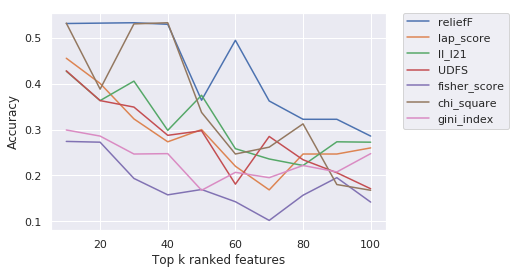

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
sns.set()
#def plot_performance(result,num_fea):
line1, = plt.plot(num_fea,FS_performance_kf5[0], label='reliefF')
line2, = plt.plot(num_fea,FS_performance_kf5[1], marker='', label='lap_score')
line3, = plt.plot(num_fea,FS_performance_kf5[2], marker='', label='ll_l21')
line4, = plt.plot(num_fea,FS_performance_kf5[3], marker='', label='UDFS')
line5, = plt.plot(num_fea,FS_performance_kf5[4], marker='', label='fisher_score')
line6, = plt.plot(num_fea,FS_performance_kf5[5], marker='', label='chi_square')
line7, = plt.plot(num_fea,FS_performance_kf5[6], marker='', label='gini_index')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Top k ranked features')
plt.ylabel('Accuracy')

### 10-fold Cross validation

In [68]:
kf10=KFold(n_splits=10,shuffle=True)

In [70]:
FS_performance_kf10=[]  
for FS in pool_FS:
    acc_k=[]
       
    for k in num_fea:
        _feature_ranking,_acc=training(kf10,k,FS)
        acc_k.append(_acc)
    FS_performance_kf10.append(acc_k)

Text(0, 0.5, 'Accuracy')

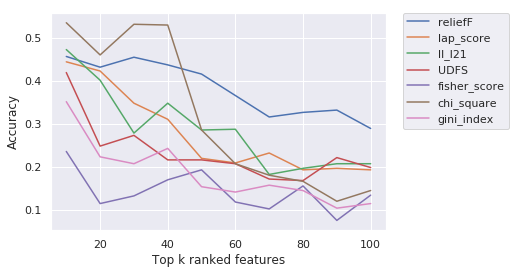

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
sns.set()
#def plot_performance(result,num_fea):
line1, = plt.plot(num_fea,FS_performance_kf10[0], label='reliefF')
line2, = plt.plot(num_fea,FS_performance_kf10[1], marker='', label='lap_score')
line3, = plt.plot(num_fea,FS_performance_kf10[2], marker='', label='ll_l21')
line4, = plt.plot(num_fea,FS_performance_kf10[3], marker='', label='UDFS')
line5, = plt.plot(num_fea,FS_performance_kf10[4], marker='', label='fisher_score')
line6, = plt.plot(num_fea,FS_performance_kf10[5], marker='', label='chi_square')
line7, = plt.plot(num_fea,FS_performance_kf10[6], marker='', label='gini_index')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Top k ranked features')
plt.ylabel('Accuracy')

### LOO

In [32]:
from sklearn.model_selection import LeaveOneOut
loo=LeaveOneOut()

In [34]:
FS_performance_loo=[]  
fea_ranking_loo=[]
for FS in pool_FS:
    acc_k=[]
    fea_ranking_=[]
       
    for k in num_fea:
        _feature_ranking,_acc=training(loo,k,FS)
        acc_k.append(_acc)
        fea_ranking_.append(_feature_ranking)
    
    FS_performance_loo.append(acc_k)
    fea_ranking_loo.append(fea_ranking_)

### store the results of loo for later use

In [39]:
#FS_performance_loo
labels_pool=['reliefF','lap_score','ll_l21','UDFS','fisher_score','chi_square','gini_index']
result_acc_loo=dict()
result_acc_loo['reliefF']=FS_performance_loo[0]
result_acc_loo['lap_score']=FS_performance_loo[1]
result_acc_loo['ll_l21']=FS_performance_loo[2]
result_acc_loo['UDFS']=FS_performance_loo[3]
result_acc_loo['fidher_score']=FS_performance_loo[4]
result_acc_loo['chi_square']=FS_performance_loo[5]
result_acc_loo['gini_index']=FS_performance_loo[6]


In [41]:
result_rank_loo=dict()
result_rank_loo['reliefF']=fea_ranking_loo[0]
result_rank_loo['lap_score']=fea_ranking_loo[1]
result_rank_loo['ll_l21']=fea_ranking_loo[2]
result_rank_loo['UDFS']=fea_ranking_loo[3]
result_rank_loo['fidher_score']=fea_ranking_loo[4]
result_rank_loo['chi_square']=fea_ranking_loo[5]
result_rank_loo['gini_index']=fea_ranking_loo[6]

In [43]:
#src_fold  = '/home/raoua/Desktop/BASIRA/working repo/Data_77subjects/RH77subjects/'
#label_file = '/home/raoua/Desktop/BASIRA/working repo/Data_77subjects/labels77.mat'
dst_fold = '/home/jupyter/project/Master_project/Results'

In [45]:
import os

In [46]:
f = os.path.join(dst_fold, 'accuracy_loo' + '.mat' )
sio.savemat(f,result_acc_loo)

In [47]:
f1 = os.path.join(dst_fold, 'ranking_loo' + '.mat' )
sio.savemat(f1,result_acc_loo)

Text(0, 0.5, 'Accuracy')

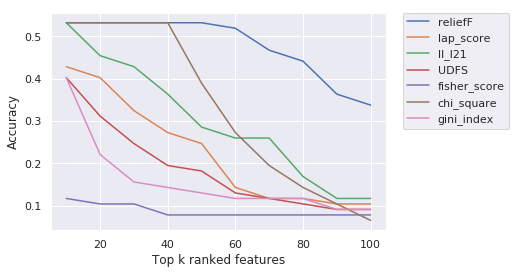

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
sns.set()
#def plot_performance(result,num_fea):
line1, = plt.plot(num_fea,FS_performance_loo[0], label='reliefF')
line2, = plt.plot(num_fea,FS_performance_loo[1], marker='', label='lap_score')
line3, = plt.plot(num_fea,FS_performance_loo[2], marker='', label='ll_l21')
line4, = plt.plot(num_fea,FS_performance_loo[3], marker='', label='UDFS')
line5, = plt.plot(num_fea,FS_performance_loo[4], marker='', label='fisher_score')
line6, = plt.plot(num_fea,FS_performance_loo[5], marker='', label='chi_square')
line7, = plt.plot(num_fea,FS_performance_loo[6], marker='', label='gini_index')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Top k ranked features')
plt.ylabel('Accuracy')

In [22]:
def avg_similarity(pool_FS,num_fea,cv):
    '''Input:
    
       pool_FS: pool of Feature selection methods
       num_fea: a list of different fs numbers in this case the threshold varies from 10 to 100 with step 10
       cv: Cross validation method (5-fold, 10_fold, LOO)
       
       Output: 
       
       average_similarity: average similarity matrix'''
    S_k={}
    similarities=[]
    for k in num_fea:
        FS_k=[]
    
        for FS in pool_FS:
            _feature_ranking,_acc=training(cv,k,FS)
            #FS_k_ranking.append(_feature_ranking)
            FS_k.append(_feature_ranking)
        S_k[k]=FS_to_FS_similarity(FS_k)
    for k in num_fea:
        similarities.append(S_k[k])
    average_similarity=sum(similarities)/len(num_fea)
    return(average_similarity)

In [23]:
from statistics import mean
import math

In [24]:
def matrix_acc(list_):
    n=len(list_)
    m=np.ones((n,n))
    for i in range(n-1):
        for j in range(i+1,n):
            m[i,j]=cost(list_[i],list_[j])
            m[j,i]=m[i,j]
    for i in range(n):
        m[i,i]=cost(list_[i],list_[i])
    
    return(m)

In [25]:
def accuracy_similarity_matrix(pool_FS,num_fea,cv):
    '''Input:
    
       pool_FS: pool of Feature selection methods
       num_fea: a list of different fs numbers in this case the threshold varies from 10 to 100 with step 10
       cv: Cross validation method (5-fold, 10_fold, LOO)
       
       Output:
       FS-to-FS Accuracy similarity matrix
       
    '''
    #avg_fs_acc_over_k={}
    avg_fs_acc_over_k=[]
    #FS_columns=['reliefF','lap_score','ll_l21','UDFS','fisher_score','chi_square','gini_index']
    for FS in pool_FS:
        acc_k=[]
        for k in num_fea:
            _feature_ranking,_acc=training(cv,k,FS)
            #avg_fs_acc_over_k[k]=
            acc_k.append(_acc)
        #avg_fs_acc_over_k[str(FS.__name__.split('.')[3])]=mean(acc_k)
        avg_fs_acc_over_k.append(mean(acc_k))
    result=matrix_acc(avg_fs_acc_over_k)
    return(result)

In [ ]:
ACC=accuracy_similarity_matrix(pool_FS,num_fea,kf5)

#### 10-Fold

In [30]:
#test=training(num_fea,reliefF)
# split data into 10 folds
kf10=KFold(n_splits=10,shuffle=True)

In [31]:
kf10.get_n_splits()

10

#### LOO

In [32]:
from sklearn.model_selection import LeaveOneOut
loo=LeaveOneOut()

In [33]:
loo.get_n_splits(X)

77

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
sns.set()
def plot_performance(result,num_fea):
    line1, = plt.plot(num_fea,result['reliefF'][0], label='reliefF')
    line2, = plt.plot(num_fea,result['lap_score'][0], marker='', label='lap_score')
    line3, = plt.plot(num_fea,result['ll_l21'][0], marker='', label='ll_l21')
    line4, = plt.plot(num_fea,result['UDFS'][0], marker='', label='UDFS')
    line5, = plt.plot(num_fea,result['CFS'][0], marker='', label='CFS')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.xlabel('Top k ranked features')
    plt.ylabel('Accuracy')
    #plt.title('Feature selection methods performance using 5-fold CV')

### -------------- Main Program ------------------

In [60]:
## import cv method here
import os
## cv=instance()
##dst_fold='bla/bla/bla'
#performance_x=main_pipeline(cv)
## due to the fact that this pipeline is time consuming I chose to save the results of the pipeline so 
## I don't have to rerun the whole pipeline from zero
dst_fold='/home/raoua/Desktop/BASIRA/working repo/intermediate/'
save_performance('Pool_FS_Accuracy_10fold',dst_fold,performance10)
## Read the performance result for later processing
#result_file= sio.loadmat('blalalalal')


In [44]:
import scipy.io as sio
result=sio.loadmat('./intermediate_RH/10_fold_RH.mat')

Text(0.5, 1.0, 'Feature selection methods performance using 10-fold CV: RH')

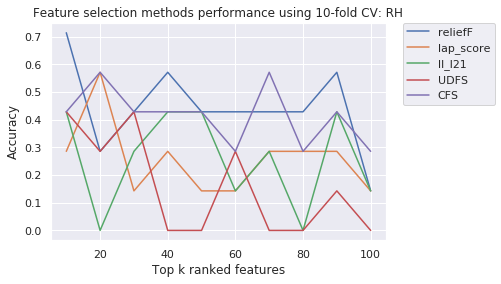

In [45]:
plot_performance(result,num_fea)
plt.title('Feature selection methods performance using 10-fold CV: RH')

### Plot the results

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
sns.set()

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


Text(0.5, 1.0, 'Feature selection methods performance using 5-fold CV')

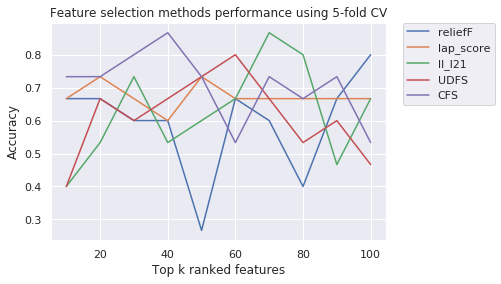

In [61]:
import matplotlib.pyplot as plt
#from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(num_fea,result['reliefF'][0], label='reliefF')
line2, = plt.plot(num_fea,result['lap_score'][0], marker='', label='lap_score')
line3, = plt.plot(num_fea,result['ll_l21'][0], marker='', label='ll_l21')
line4, = plt.plot(num_fea,result['UDFS'][0], marker='', label='UDFS')
line5, = plt.plot(num_fea,result['CFS'][0], marker='', label='CFS')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Top k ranked features')
plt.ylabel('Accuracy')
plt.title('Feature selection methods performance using 5-fold CV')